In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [ ]:
(path/"train").ls()

(#5012) [Path('/home/manas/.fastai/data/pascal_2007/train/005190.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/002090.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/000463.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/007883.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/004783.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/002940.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/008332.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/002120.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/001136.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/006198.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/007555.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/009455.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/005852.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/001229.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/008012.jpg'),Path('/home/manas/.fastai/data/pascal_2007/train/000633.jpg')

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
df.iloc[:,0],df.iloc[0]

(0       000005.jpg
 1       000007.jpg
 2       000009.jpg
 3       000012.jpg
 4       000016.jpg
            ...    
 5006    009954.jpg
 5007    009955.jpg
 5008    009958.jpg
 5009    009959.jpg
 5010    009961.jpg
 Name: fname, Length: 5011, dtype: object,
 fname       000005.jpg
 labels           chair
 is_valid          True
 Name: 0, dtype: object)

In [5]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('009465.jpg', 'horse')

In [7]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/manas/.fastai/data/pascal_2007/train/008811.jpg'), ['bicycle'])

In [8]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x334,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
                      0., 0., 0., 0., 0.]))

In [9]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['motorbike']

To actually open the image and do the conversion to tensors, we will need to use a set
of transforms; block types will provide us with those. We can use the same block
types that we have used previously, with one exception: the ImageBlock will work fine
again, because we have a path that points to a valid image, but the CategoryBlock is
not going to work. The problem is that block returns a single integer, but we need to
be able to have multiple labels for each item. To solve this, we use a MultiCategory
Block. This type of block expects to receive a list of strings,

We have ignored the column is_valid up until now, which means that DataBlock
has been using a random split by default. To explicitly choose the elements of our val‐
idation set, we need to write a function and pass it to splitter (or use one of fastai’s
predefined functions or classes). It will take the items (here our whole DataFrame)
and must return two (or more) lists of integers:

In [10]:
def splitter(df):
    train = df.index[~df['is_valid']].toList()
    valid = df.index[df['is_valid']].tolist()
    return train,valid
#for now we will use custom splitter 


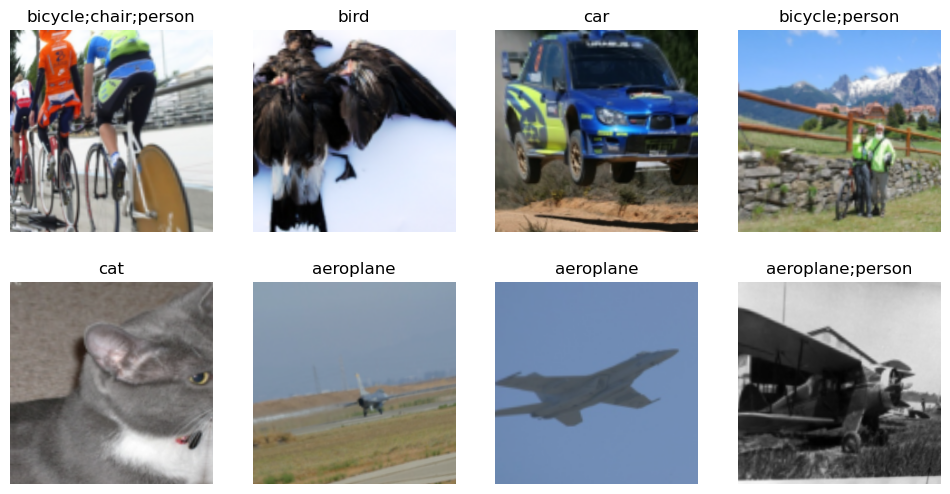

In [11]:
#Lets just take a bit of a look at the images from the dataset
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x=ColReader('fname', pref=f'{path}/train/'),
                   get_y=ColReader('labels', label_delim=' '),
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=RandomResizedCrop(128,min_scale=0.35),
                   batch_tfms=aug_transforms(size=224))

# We pass the dataframe as the data source to dataloaders
dls = dblock.dataloaders(df,bs = 8)

# 5. Display a batch of images
dls.show_batch(max_n=16)

We can create a Datasets object from this. The only thing needed is a source—in this
case, our DataFrame:
dsets = dblock.datasets(df)
This contains a train and a valid dataset, which we can index into:

In [12]:
dsets.train[0]

(PILImage mode=RGB size=500x334,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
                      0., 0., 0., 0., 0.]))

Now we’ll create our Learner .Learner object contains
four main things: the model, a DataLoaders object, an Optimizer,

In [13]:
learn = vision_learner(dls,resnet18)


the model in a Learner is generally an object of a class inheriting
from nn.Module, and that we can call it using parentheses and it will return the acti‐
vations of a model.

In [14]:
x,y = dls.one_batch()
activs = learn.model(x)
activs.shape


torch.Size([8, 20])

In [15]:
activs[0]

TensorImage([-0.3571,  1.3152, -0.5269,  0.8478,  1.4386,  1.4514,  3.5282,
              2.8740,  0.3792,  4.2424,  1.6056, -0.9376, -1.0323,  3.1461,
             -2.4363, -0.1774,  3.0605,  0.1070, -1.7032,  1.5429],
            grad_fn=<AliasBackward0>)

They are not sclaed between 0 and 1 so we will scale it by using sigmoid function

In [16]:
import torch
def binary_cross_entropy(inputs,targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets == 1,inputs,1-inputs).log().mean()


The BCCwithlogits loss function is an alternative name for the Binary Cross-Entropy with Logits Loss or BCEWithLogitsLoss in PyTorch

In [17]:
def accuracy(inp,targ,axis=-1):
    pred = inp.argmax(dim = axis)
    return (pred==targ).float().mean()

“Regular” accuracy checks if all labels exactly match—too strict. In multi-label we:

threshold each sigmoid output (e.g., > 0.5), then

compute per-example set metrics: accuracy_multi(thresh=0.5), F1, precision/recall (micro/macro), or per-label accuracy.
These reflect partial correctness and class imbalance better.

In [18]:
from functools import partial
from fastai.vision.all import *

# Define the correct multi-label accuracy function
def multi_accuracy(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp > thresh) == targ.bool()).float().mean()


In [19]:


# Now, create your learner using the correct metric name
learn = vision_learner(dls, resnet50, metrics=partial(multi_accuracy, thresh=0.2))

# Train your model
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,multi_accuracy,time
0,0.585951,0.358708,0.463872,06:36
1,0.174003,0.114374,0.950998,06:36
2,0.153532,0.103736,0.960080,06:34
3,0.144751,0.098525,0.958832,06:28


epoch,train_loss,valid_loss,multi_accuracy,time
0,0.129087,0.092413,0.960080,09:34
1,0.123097,0.084646,0.961178,09:16
2,0.097904,0.080709,0.966168,08:44


In [20]:
preds,targs = learn.get_preds()

In [21]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9595)

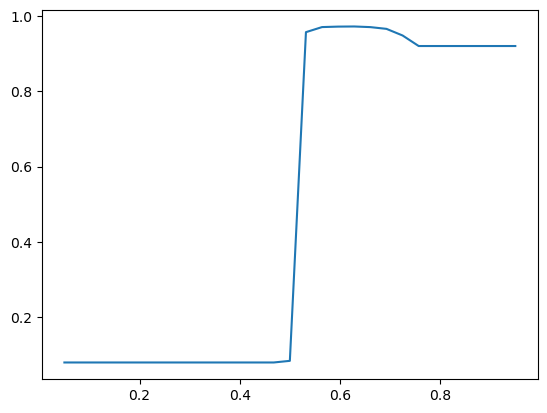

In [22]:
#We can now use this approach to find the best threshold level:
import matplotlib.pyplot as plt
xs = torch.linspace(0.05,0.95,29)
accs = [multi_accuracy(preds,targs,thresh=i) for i in xs]
plt.plot(xs,accs)

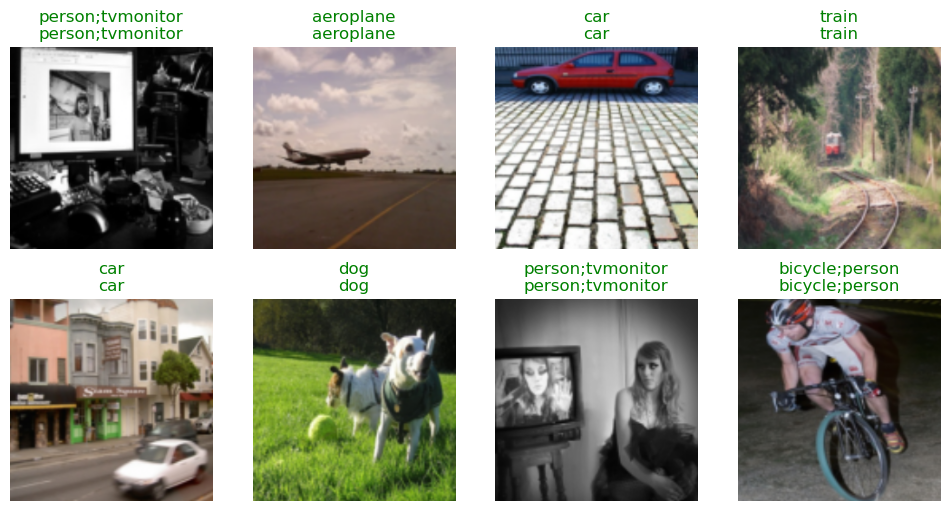

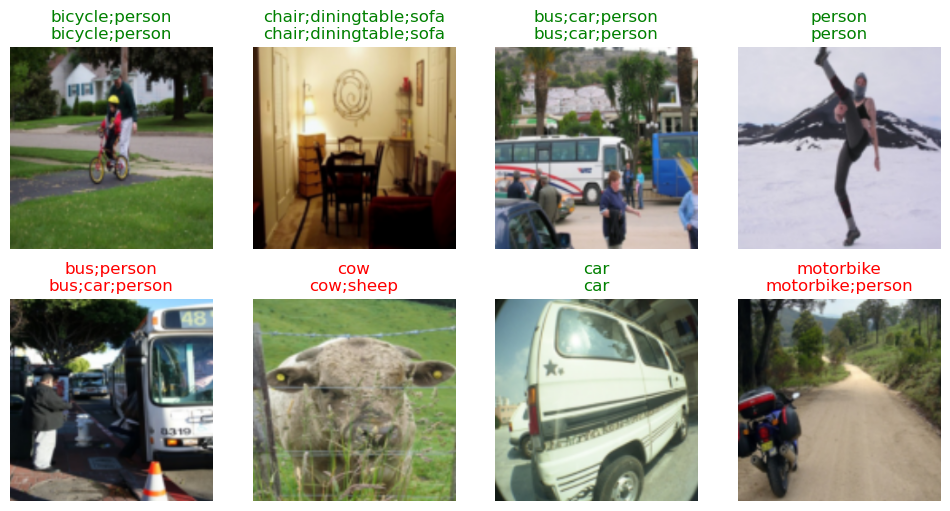

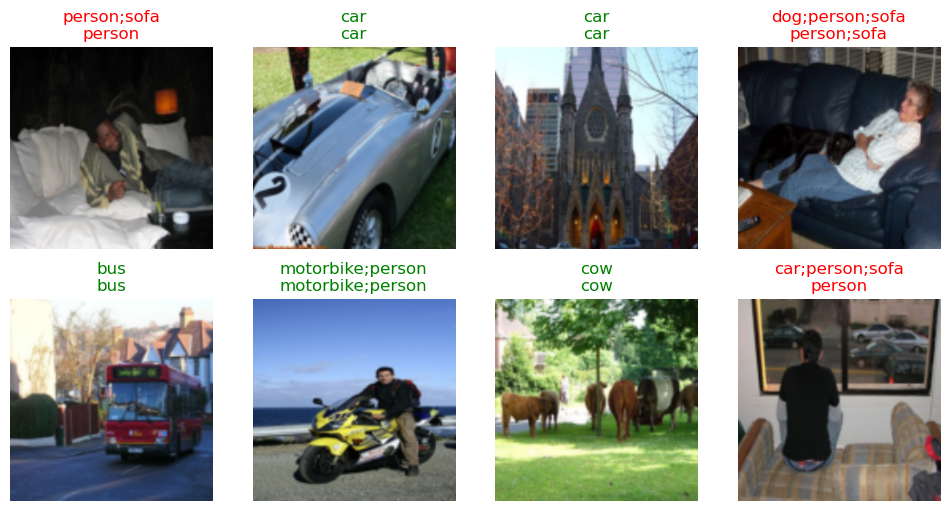

In [ ]:
#these are sme of the prediction from the model
learn.show_results(max_n=16)
learn.show_results(max_n=16)
learn.show_results(max_n=16)

In [28]:
#lets just save the model for now
custom_path = Path('./models')
learn.save(custom_path/'Multi-label-model')

Path('models/models/Multi-label-model.pth')

In [33]:
preds, targs = learn.get_preds()

In [34]:
# Convert the raw predictions to binary (0s and 1s) using a threshold
thresh = 0.2
binary_preds = (preds > thresh).long()

In [35]:
from sklearn.metrics import classification_report

# Get the list of class names from your data
class_names = dls.vocab

# Generate the classification report
report = classification_report(targs, binary_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

   aeroplane       0.97      0.94      0.95        33
     bicycle       0.94      0.79      0.86        42
        bird       0.93      0.96      0.94        67
        boat       0.77      0.87      0.81        38
      bottle       0.53      0.68      0.59        56
         bus       0.81      0.86      0.84        44
         car       0.78      0.82      0.80       137
         cat       0.94      0.87      0.90        76
       chair       0.62      0.81      0.70       130
         cow       0.68      0.82      0.74        33
 diningtable       0.68      0.76      0.72        58
         dog       0.93      0.83      0.88        86
       horse       0.90      0.70      0.79        50
   motorbike       0.83      0.93      0.88        46
      person       0.78      0.90      0.84       420
 pottedplant       0.59      0.52      0.55        62
       sheep       0.65      0.69      0.67        16
        sofa       0.61    

/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Predicted labels: ['bicycle', 'person']
Probabilities: tensor([4.5072e-05, 9.5333e-01, 4.9283e-04, 1.3177e-04, 1.0798e-03, 8.7537e-05,
        7.3220e-04, 2.9488e-05, 1.0501e-02, 7.7730e-07, 4.5372e-05, 1.4397e-04,
        5.2498e-04, 4.9105e-05, 9.5519e-01, 1.1817e-04, 1.1473e-06, 2.1606e-04,
        3.8074e-05, 1.4457e-04])


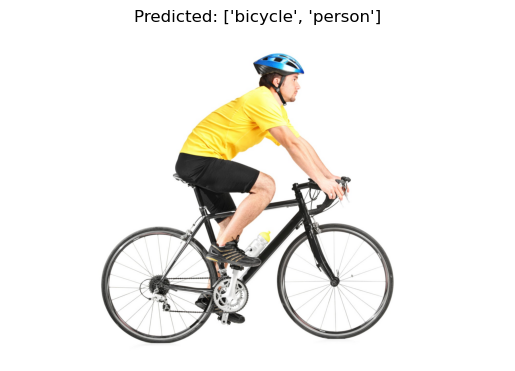

In [39]:
# Assuming you have a new image file
img_path = './resources/multi-lable-text.png'

# Make a prediction
# The result is a tuple: (predicted labels, tensor of indices, tensor of probabilities)
pred, pred_idx, probs = learn.predict(img_path)

# Print the predicted labels and their probabilities
print(f"Predicted labels: {pred}")
print(f"Probabilities: {probs}")
img = Image.open(img_path)

# Use matplotlib to display the image
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title(f"Predicted: {pred}")
plt.show()

Predicted labels: ['bicycle', 'car', 'person']
Probabilities: tensor([2.5584e-05, 8.3668e-01, 3.1219e-04, 4.1735e-03, 2.4408e-03, 3.3672e-02,
        5.8200e-01, 1.2409e-04, 1.5907e-02, 2.9076e-05, 1.9696e-03, 4.9301e-04,
        1.1808e-03, 2.7542e-02, 9.1972e-01, 6.5550e-02, 2.1099e-05, 9.9379e-04,
        4.6498e-04, 4.4331e-04])


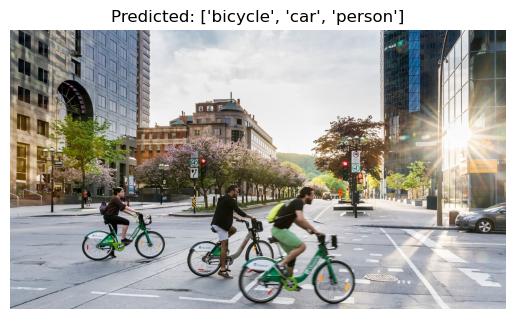

In [40]:
# Assuming you have a new image file
img_path = './resources/multi-label-classification-2.png'

# Make a prediction
# The result is a tuple: (predicted labels, tensor of indices, tensor of probabilities)
pred, pred_idx, probs = learn.predict(img_path)

# Print the predicted labels and their probabilities
print(f"Predicted labels: {pred}")
print(f"Probabilities: {probs}")
img = Image.open(img_path)

# Use matplotlib to display the image
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title(f"Predicted: {pred}")
plt.show()

Predicted labels: ['car']
Probabilities: tensor([3.6741e-04, 6.9237e-02, 8.8831e-04, 1.8055e-02, 2.6854e-03, 3.0440e-02,
        8.4573e-01, 1.0814e-03, 4.0949e-02, 2.4067e-04, 1.3209e-02, 1.2556e-04,
        1.4469e-04, 1.1128e-02, 3.0585e-01, 3.1038e-01, 3.5755e-05, 1.4575e-03,
        1.3915e-03, 2.3886e-03])


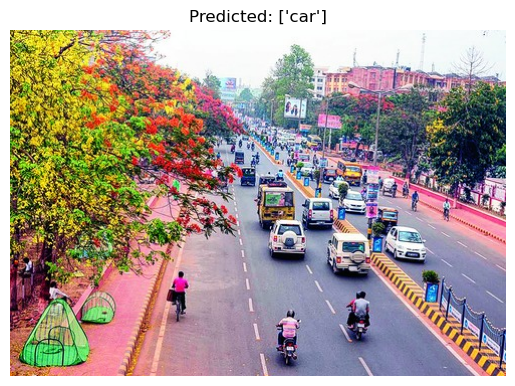

In [41]:
# Assuming you have a new image file
img_path = './resources/multi-label-classification-3.png'

# Make a prediction
# The result is a tuple: (predicted labels, tensor of indices, tensor of probabilities)
pred, pred_idx, probs = learn.predict(img_path)

# Print the predicted labels and their probabilities
print(f"Predicted labels: {pred}")
print(f"Probabilities: {probs}")
img = Image.open(img_path)

# Use matplotlib to display the image
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title(f"Predicted: {pred}")
plt.show()